## 1.训练Image分类模型——CNN

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images

torch.manual_seed(1)    # reproducible

In [2]:
# Hyper Parameters
EPOCH = 1
BATCH_SIZE = 50
LR = 0.001          # 学习率
DOWNLOAD_MNIST = False

In [3]:
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=DOWNLOAD_MNIST,
)
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)

In [4]:
train = list()
test = list()

In [5]:
for i in range(0,10):
    train.append((torch.Tensor(gray2rgb(np.array(train_data[i][0])).reshape(28,28,3)),train_data[i][1]))
    #Y_train.append(train_data[i][1])

In [6]:
for i in range(0,10):
    test.append((torch.Tensor(gray2rgb(np.array(test_data[i][0])).reshape(28,28,3)),test_data[i][1]))

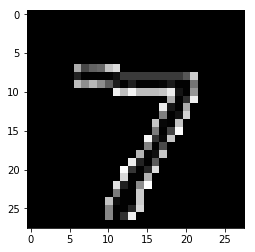

In [7]:
plt.imshow(np.array(test[0][0]))

In [8]:
# 批训练 50samples, 1 channel, 28x28 (50, 3, 28, 28)
train_loader = Data.DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True)
#test_x = torch.unsqueeze(test_data.data, dim=1).type(torch.FloatTensor)[:2000]/255.
#test_y = test_data.targets[:2000]

### 定义神经网络

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(  # input shape (3, 28, 28)
            nn.Conv2d(
                in_channels=3,      # input height
                out_channels=16,    # n_filters
                kernel_size=5,      # filter size
                stride=1,           # filter movement/step
                padding=2,      # 如果想要 con2d 出来的图片长宽没有变化, padding=(kernel_size-1)/2 当 stride=1
            ),      # output shape (16, 28, 28)
            nn.ReLU(),    # activation
            nn.MaxPool2d(kernel_size=2),    # 在 2x2 空间里向下采样, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(  # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),  # output shape (32, 14, 14)
            nn.ReLU(),  # activation
            nn.MaxPool2d(2),  # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = torch.Tensor(x)
        x = x.reshape(-1,3,28,28)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)   # 展平多维的卷积图成 (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output

In [10]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


### 模型训练

In [11]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted

In [12]:
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # 分配 batch data, normalize x when iterate train_loader
        output = cnn(b_x)               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        if step % 100 == 0:
            print("Step:{} Loss:{}".format(step,loss))

Step:0 Loss:2.302663803100586
Step:100 Loss:0.18354345858097076
Step:200 Loss:0.28644779324531555
Step:300 Loss:0.39474427700042725
Step:400 Loss:0.31586167216300964
Step:500 Loss:0.48773735761642456
Step:600 Loss:0.28015759587287903
Step:700 Loss:0.12532995641231537
Step:800 Loss:0.23947758972644806
Step:900 Loss:0.17135539650917053
Step:1000 Loss:0.10992328822612762
Step:1100 Loss:0.3246319591999054


### 保存模型

In [13]:
torch.save(cnn.state_dict(), 'Mnist_CNN.pkl')

## 使用Lime解释模型

In [11]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

In [12]:
cnn_copy = CNN()
cnn_copy.load_state_dict(torch.load('Mnist_CNN.pkl'))
logits = cnn_copy(torch.unsqueeze(test[0][0],dim=0))
print(F.softmax(logits, dim=1))

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], grad_fn=<SoftmaxBackward>)


In [28]:
def getResult(image):
    logits = cnn_copy(image)
    probs = F.softmax(logits, dim=1)
    return probs.detach().numpy()

In [43]:
explainer = lime_image.LimeImageExplainer()
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)
explanation = explainer.explain_instance(np.array(train[2][0]), 
                                         getResult, # classification function
                                         top_labels=10, 
                                         hide_color=0, 
                                         num_samples=100,
                                        segmentation_fn=segmenter) # number of images that will be sent to classification function

In [55]:
temp, mask = explanation.get_image_and_mask(train[3][1], positive_only=True, num_features=10, hide_rest=False)


Text(0.5,1,'Positive/Negative Regions for 4')

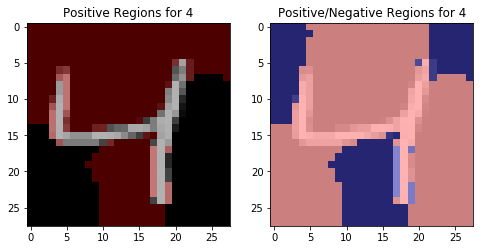

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(train[2][1]))
temp, mask = explanation.get_image_and_mask(train[2][1], positive_only=False, num_features=10, hide_rest=False)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(train[2][1]))


In [46]:
print(explanation.local_exp)

{5: [(3, -0.07026896053953913), (4, -0.0629916348569722), (2, -0.033556322772982275), (0, 0.020364392686964643), (5, 0.01447985499251692), (1, 0.007895969413574979)], 1: [(4, -0.16520433804481424), (3, -0.16265269670506877), (0, 0.05123390715916622), (5, 0.03097527139453515), (2, 0.009678548817165995), (1, 0.00551940432736456)], 0: [(3, -0.010336588971687006), (4, -0.009348098379011344), (0, 0.003111929001574834), (2, 0.0023915862422822583), (5, -0.0015064589851854723), (1, 0.00017617063341106778)], 6: [(3, -0.01966134554589156), (2, -0.009351224463648144), (5, 0.006251006861032755), (4, -0.005182560919384014), (0, 0.0026127811140863066), (1, 0.0016568801476049635)], 8: [(3, -0.022153255429917026), (2, 0.004906090174993444), (5, 0.004159735672771083), (1, 0.0014244742314825447), (0, 0.0004924090972276366), (4, 0.00020528462629588115)], 7: [(4, -0.1423356480712968), (5, -0.06402068917217096), (3, 0.03225486148589113), (2, -0.016326306346459245), (0, -0.006891869964815261), (1, -0.004868

In [47]:
print(mask)

[[1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1]
 [1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1]
 [1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1]
 [1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1]
 [1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1]
 [1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 1 1 1]
 [1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1]
 [1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1]
 [1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 

In [48]:
print(explanation.segments)

[[0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1]
 [0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1]
 [0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1]
 [0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1]
 [0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 3 1 1 1 1 1 1]
 [0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 1 1 1 1 1 1]
 [0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 1 3 3 3 3 1]
 [0 0 0 0 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3]
 [0 0 0 0 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 2 4 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3]
 [4 4 4 2 4 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [4 4 4 2 4 4 4 4 4 4 4 4 4 4 3 3 5 5 3 3 3 3 3 3 3 3 3 3]
 [4 4 4 4 2 4 4 4 4 4 3 2 5 5 5 5 5 3 3 3 3 3 3 3 3 3 3 